<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumSubjectsRegression_07_Keras_optimise_mse_30_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

# df_annotations = pd.read_csv("all_annotations.csv")


# Get data

In [3]:
# with open("protocols.pkl.gz", "rb") as f:
#     file_to_pages = pkl.load(f)

In [4]:
# import spacy
# nlp = spacy.blank("en")

In [5]:
# texts = []

# for i in range(len(df_annotations)):
#     file_name = df_annotations.file.iloc[i]
    
#     pages= file_to_pages[file_name]
    
#     text = ""
#     for page in pages:
#         doc = nlp(page)
        
#         is_include = [False] * len(doc)
#         for tok in doc:
#             if tok.text.lower() in {"phase"}:
#                 for token_index in range(tok.i - 20, tok.i + 20):
#                     if token_index >= 0 and token_index < len(doc):
#                         is_include[token_index] = True
        
#         for token_index in range(len(doc)):
#             if is_include[token_index]:
#                 text += doc[token_index].text + doc[token_index].whitespace_
                
                
#     if text == "":
#         print ("nothing found", file_name, df_annotations.phase.iloc[i])
#         text = " ".join(pages)
#         if len(text) > 100000:
#             text = text[:100000]
#     else:
#         print ("found", file_name, df_annotations.phase.iloc[i])

#     texts.append(text)
# df_annotations["text"] = texts

In [6]:
# df_annotations.to_csv("filtered_for_phase.csv.bz2")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df_annotations= pd.read_csv("/content/drive/MyDrive/data/filtered_for_phase_arms_subjects_02.csv.bz2")

In [9]:
#df_annotations.text = df_annotations.text.apply(lambda t : t[:10000] if len(t) > 10000 else t)

In [10]:
def get_num_subjects_clean(num):
    if pd.isna(num):
        return None
    if num >= 10000:
        return "10000+"
    if num >= 1000:
        return "1000+"
    if num >= 500:
        return "500+"
    if num >= 200:
        return "200+"
    if num >= 100:
        return "100+"
    if num >= 50:
        return "50+"
    if num >= 25:
        return "25+"
    return "1-24"
df_annotations["num_subjects_clean"] = df_annotations["num_subjects"].apply(get_num_subjects_clean)

In [11]:
df_annotations["num_subjects_clean"].value_counts()

1-24      2980
25+       2119
50+       2016
100+      1674
200+      1656
500+       816
1000+      547
10000+     112
Name: num_subjects_clean, dtype: int64

In [12]:
# df_annotations = pd.read_csv("filtered_for_phase.csv.bz2")

In [13]:
# del file_to_pages

In [14]:
phase_map = {"Phase 2":"2",
"Phase 3":"3",
"Phase 4":"4",
"Phase 1":"1",
"Phase 1/Phase 2":"1.5",
"Not Applicable":"0",
"Phase 2/Phase 3":"2.5",
"Early Phase 1":"0.5"}
df_annotations["phase_clean"] = df_annotations["phase"].apply(lambda x : phase_map.get(x, None))

In [15]:
phase_clean_map = {}
for idx, val in enumerate(sorted(set(phase_map.values()), key = lambda x : float(x))):
  phase_clean_map[val] = idx
# invert the dictionary
phase_lookup = {v: k for k, v in phase_clean_map.items()}

phase_list = [phase_lookup[x] for x in sorted(phase_lookup)]
phase_list

['0', '0.5', '1', '1.5', '2', '2.5', '3', '4']

In [16]:
def get_num_arms_clean(num):
    if pd.isna(num):
        return None
    if num >= 5:
        num = 5
    return num
df_annotations["num_arms_clean"] = df_annotations["num_arms"].apply(get_num_arms_clean)

# Begin Keras/TF

In [17]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [18]:
num_subjects_clean_map = {}
for idx, val in enumerate(sorted(set(df_annotations[~df_annotations.num_subjects_clean.isna()].num_subjects_clean), key = lambda x : int(re.sub(r'\D.*$', '', x)))):
  num_subjects_clean_map[val] = idx

In [19]:
# invert the dictionary
num_subjects_lookup = {v: k for k, v in num_subjects_clean_map.items()}

In [20]:
num_subjects_list = [num_subjects_lookup[x] for x in sorted(num_subjects_lookup)]
num_subjects_list

['1-24', '25+', '50+', '100+', '200+', '500+', '1000+', '10000+']

In [21]:
num_subjects_clean_map

{'1-24': 0,
 '25+': 1,
 '50+': 2,
 '100+': 3,
 '200+': 4,
 '500+': 5,
 '1000+': 6,
 '10000+': 7}

In [22]:
def get_one_hot_num_subjects(x):
  a = [0] * len(num_subjects_clean_map)
  if x is None:
    return a
  a[num_subjects_clean_map[x]] = 1
  return a

In [23]:
df_annotations["num_subjects_one_hot"] = df_annotations["num_subjects_clean"].apply(get_one_hot_num_subjects)

In [24]:
df_annotations["num_subjects_one_hot"] = df_annotations["num_subjects_clean"].apply(get_one_hot_num_subjects)

In [25]:
def get_one_hot_num_arms(x):
  a = [0] * 5
  if x is not None and not pd.isna(x):
    a[int(x - 1)] = 1
  return a
df_annotations["num_arms_one_hot"] = df_annotations["num_arms_clean"].apply(get_one_hot_num_arms)

In [26]:
def get_one_hot_phase(x):
  a = [0] * len(phase_clean_map)
  if x is None:
    return a
  a[phase_clean_map[x]] = 1
  return a
df_annotations["phase_one_hot"] = df_annotations["phase_clean"].apply(get_one_hot_phase)

Concatenate the three bits of one-hot data into one column

In [27]:
concatenated_one_hot = []
for i in range(len(df_annotations)):
  concatenated = list(df_annotations.phase_one_hot.iloc[i]) + \
  list(df_annotations.num_arms_one_hot.iloc[i]) + \
  list(df_annotations.num_subjects_one_hot.iloc[i]) + [df_annotations.has_sap.iloc[i]]
  concatenated_one_hot.append(concatenated)
df_annotations["concatenated_one_hot"] = concatenated_one_hot

In [28]:
np.sum(np.asarray([np.asarray(x) for x in df_annotations["concatenated_one_hot"]]), axis=1).mean()

nan

In [29]:
np.sum(np.asarray([np.asarray(x) for x in df_annotations["concatenated_one_hot"]]), axis=0)

array([ 519.,  135., 1154.,  983., 4317.,  297., 2725., 1461., 3086.,
       5228., 1456.,  908.,  913., 2980., 2119., 2016., 1674., 1656.,
        816.,  547.,  112.,   nan])

In [30]:
num_classes = len(concatenated)
print (f"There are {num_classes} classes in this multi-label classifier")

There are 22 classes in this multi-label classifier


In [31]:
df_train = df_annotations[df_annotations.train_val == "train"]
df_val = df_annotations[df_annotations.train_val == "val"]

In [32]:
df_train_got_some_ground_truths = df_train[~df_train.num_subjects.isna()]

In [33]:
len(df_train_got_some_ground_truths), len(df_train)

(9535, 9538)

In [34]:
train_labels = np.asarray(list(df_train_got_some_ground_truths.num_subjects))
test_labels = np.asarray(list(df_val.num_subjects))

In [35]:
train_examples = np.asarray(list(df_train_got_some_ground_truths.text))
test_examples = np.asarray(list(df_val.text))

In [36]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 9535, test entries: 1085


In [37]:
train_labels[:10]

array([193., 668.,  32.,  50.,  25., 230.,  28.,  94.,  68., 217.])

In [38]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 3.8062613e+00, -8.5627154e-02,  2.1885273e+00,  1.2064425e+00,
         1.1741788e+00, -1.6362848e+00, -1.6544684e+00,  1.9301386e+00,
        -7.3246288e-01, -2.0803753e-01, -1.8835599e+00, -8.1751305e-01,
         1.3482304e+00, -4.1169381e+00,  1.1123058e+00, -2.7861402e+00,
         3.6909611e+00, -2.2455294e+00,  1.1222224e+00,  1.9886566e+00,
        -1.0249604e-01,  2.6178288e+00,  3.5085483e+00, -7.0547515e-01,
         1.2558808e+00, -1.6434602e+00, -1.1090916e+00,  4.3890409e+00,
        -1.7149318e+00, -2.8435621e+00,  1.0796951e+00,  2.6536503e+00,
        -3.8684306e-01, -3.1688907e+00,  1.0274379e-01, -2.0242805e+00,
         2.3353672e+00, -1.7880658e+00,  5.3773862e-01, -1.0440906e+00,
        -9.3668759e-01, -1.6973139e+00, -1.4264782e-01,  2.6114061e+00,
         5.0076956e-01, -1.2994319e+00,  9.0301037e-01, -1.4811747e+00,
         8.1332225e-01,  2.3800061e+00],
       [ 2.5299299e+00,  6.9842733e-02,  1.220

In [39]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='adam',
              loss=tf.losses.MeanSquaredError(),
              metrics=[tf.metrics.MeanAbsolutePercentageError(name='mape'), tf.metrics.MeanAbsoluteError(name='mae'), tf.metrics.RootMeanSquaredError(name='rmse')],
              run_eagerly=True)

In [42]:
# x_val = train_examples[:10000]
# partial_x_train = train_examples[10000:]

# y_val = train_labels[:10000]
# partial_y_train = train_labels[10000:]

partial_x_train = train_examples
x_val = test_examples

partial_y_train = train_labels
y_val = test_labels

In [43]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
19/19 [==============================] - 9s 276ms/step - loss: 195555280.0000 - mape: 2685350.5000 - mae: 918.5573 - rmse: 13984.1074 - val_loss: 943353600.0000 - val_mape: 6402355.5000 - val_mae: 1467.2103 - val_rmse: 30714.0605
Epoch 2/30
19/19 [==============================] - 5s 257ms/step - loss: 195540704.0000 - mape: 7636568.0000 - mae: 910.6647 - rmse: 13983.5869 - val_loss: 943340224.0000 - val_mape: 13975548.0000 - val_mae: 1459.5302 - val_rmse: 30713.8438
Epoch 3/30
19/19 [==============================] - 5s 254ms/step - loss: 195523184.0000 - mape: 15497542.0000 - mae: 903.2548 - rmse: 13982.9600 - val_loss: 943321344.0000 - val_mape: 24929892.0000 - val_mae: 1452.2344 - val_rmse: 30713.5352
Epoch 4/30
19/19 [==============================] - 5s 253ms/step - loss: 195494848.0000 - mape: 27718126.0000 - mae: 896.9689 - rmse: 13981.9473 - val_loss: 943295488.0000 - val_mape: 40536680.0000 - val_mae: 1447.3038 - val_rmse: 30713.1152
Epoch 5/30
19/19 [=============

In [44]:
# model.save('num_subjects_model_06_keras.keras')

In [45]:
# model.save("/content/drive/MyDrive/data/num_subjects_model_06_keras.keras")

In [46]:
results = model.evaluate(test_examples, test_labels)

print(results)

34/34 [==============================] - 1s 25ms/step - loss: 941804224.0000 - mape: 387577184.0000 - mae: 1688.6732 - rmse: 30688.8262
[941804224.0, 387577184.0, 1688.6732177734375, 30688.826171875]


In [47]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mape', 'mae', 'rmse', 'val_loss', 'val_mape', 'val_mae', 'val_rmse'])

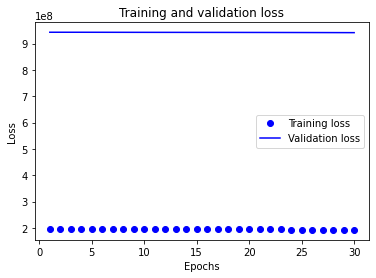

In [48]:
acc = history_dict['mape']
val_acc = history_dict['val_mape']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

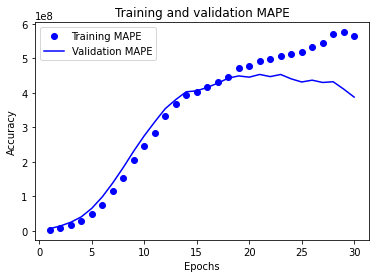

In [49]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training MAPE')
plt.plot(epochs, val_acc, 'b', label='Validation MAPE')
plt.title('Training and validation MAPE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [50]:
input_texts= np.asarray(df_val.text)

In [51]:
pred_proba = model.predict(input_texts)

34/34 [==============================] - 1s 16ms/step


In [52]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_val.num_subjects, pred_proba)

1688.6731960397713

In [53]:
df_val["y_pred_num_subjects"] = [get_num_subjects_clean(x[0]) for x in  pred_proba]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(array([ 1.,  3.,  4.,  5.,  4.,  6.,  5.,  4.,  5.,  8.,  4.,  3.,  4.,
         7.,  4.,  8.,  8., 10., 13., 10.,  8., 10., 16.,  4., 11., 16.,
        10., 12., 13., 11., 13., 10., 10., 13., 16., 22., 14., 16., 15.,
        13., 12., 13., 10., 12., 15., 19., 13., 22.,  9., 16., 11., 17.,
        15., 16., 11., 10., 11., 13., 12., 10., 13., 11., 14.,  7.,  6.,
        11.,  9.,  9., 14., 13., 12., 13., 10.,  4., 16.,  5., 15.,  8.,
         9.,  6.,  9.,  8., 10., 10.,  4.,  8.,  2.,  9.,  3.,  9.,  4.,
         6.,  1.,  4., 11.,  0.,  3.,  5.,  1.,  3.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
         450.,  460.,  470.,  480.,  490.,  500.,  510.,  520.,  530.,
        

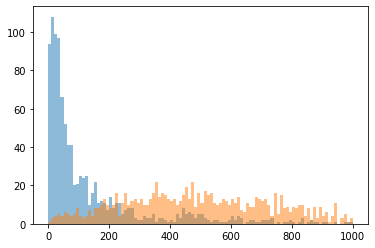

In [54]:
plt.hist(df_val.num_subjects, range=(0,1000),bins=100, alpha=0.5 )
plt.hist(pred_proba, range=(0,1000),bins=100, alpha=0.5 )

## Subjects

In [55]:
acc = accuracy_score(df_val.num_subjects_clean, df_val["y_pred_num_subjects"])
print (f"Subjects accuracy {acc}")

Subjects accuracy 0.1032258064516129


''

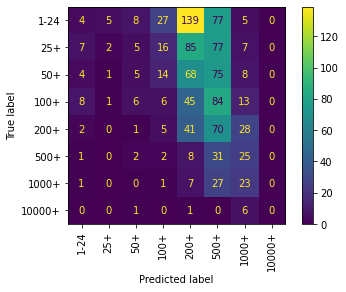

In [56]:
ConfusionMatrixDisplay.from_predictions(df_val.num_subjects_clean, df_val["y_pred_num_subjects"], labels=num_subjects_list)
plt.xticks(rotation=90)
;

In [57]:
num_correct = 0
for idx in range(len(df_val)):
  gt = num_subjects_clean_map[df_val["num_subjects_clean"].iloc[idx]]
  pred = num_subjects_clean_map[df_val["y_pred_num_subjects"].iloc[idx]]
  is_correct = int(np.abs(gt - pred) <= 1)
  num_correct += is_correct
print ("Accuracy including adjacent groups", num_correct/len(df_val))

Accuracy including adjacent groups 0.3096774193548387
